In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| default_exp hierarchy

In [ ]:
#| export
#import numpy as np
from os import sep
import uuid
from pct.nodes import PCTNode
from pct.functions import WeightedSum
from pct.putils import UniqueNamer, FunctionsList, list_of_ones
from pct.functions import BaseFunction, HPCTFUNCTION
from pct.environments import EnvironmentFactory
from pct.errors import BaseErrorCollector
from pct.putils import floatListsToString
# from inspect import isfunction

In [ ]:
#| include: false
from pct.functions import Proportional

In [ ]:
#| export
class FunctionsData():
    "Data collected for a set of functions"
    def __init__(self):
        self.data = {}
            
    def add_data(self, func):
        name = func.get_name()
        if name in self.data.keys():
            self.data[name].append(func.get_value())
        else:
            dlist=[]
            self.data[name]=dlist
            self.data[name].append(func.get_value())
    
    def add_reward(self, func):
        name = 'reward'
        if name in self.data.keys():
            self.data[name].append(func.get_reward())
        else:
            dlist=[]
            self.data[name]=dlist
            self.data[name].append(func.get_reward())
            
    def add_list(self, key, list):
        self.data[key]= list

In [ ]:
#| export
class PCTRunProperties():
    
    # def __init__(self):
    #     self.environment_properties = {} 
    #     self.hpct_structure_properties = {}
    #     self.hpct_run_properties = {}
    #     self.file_properties = {}
    #     self.wrapper_properties = {}

    
    def load_db(self, file):
        "Load properties from file."
        from jproperties import Properties
        skip = ['raw', 'env', 'col', '', '', '', '', '', '']
        # read properties from file
        configs = Properties()
        #print(file)
        with open(file, 'rb') as config_file:
            configs.load(config_file)

        items_view = configs.items()
        self.db = {}
        for item in items_view:
            if item[0] in skip:
                continue
            if item[0].startswith('level'):
                continue
            self.db[item[0]] = item[1].data

        if 'environment_properties' in self.db:                    
            ep = eval(self.db['environment_properties'])
            if 'reward_type' in ep:
                self.db['reward_type'] = ep['reward_type']

    def get_error_properties(self):
        "Get properties of error function from loaded properties list of the form propertyn."
        error_properties = []
        for property in range(1, 100):
            property_key = f'property{property}'
            if property_key in self.db:
                property_string = self.db[property_key]
                strarr = property_string.split(':')
                if strarr[0] == 'error':
                    parr = strarr[1].split(',')
                    prop=[]
                    prop.append(parr[0])
                    prop.append(parr[1])
                    error_properties.append(prop)
        return error_properties


## Defining the Hierarchy

Defining the PCTHierarchy   

In [ ]:
#| export
class PCTHierarchy():
    "A hierarchical perceptual control system, of PCTNodes."
    def __init__(self, levels=0, cols=0, pre=None, post=None, name="pcthierarchy", clear_names=True, links="single", 
                 history=False, build=True, error_collector=None, namespace=None, **pargs):
        if namespace ==None:
            namespace = uuid.uuid1()
        self.namespace=namespace

        self.error_collector=error_collector
        self.links_built = False
        self.order=None
        self.history=history
        if clear_names:
            UniqueNamer.getInstance().clear(namespace=namespace)
        self.name=UniqueNamer.getInstance().get_name(namespace=namespace, name=name)
        if pre==None:
            self.preCollection=[]
        else:            
            self.preCollection=pre
        if post==None:
            self.postCollection=[]
        else:                 
            self.postCollection=post
        self.hierarchy = []
        self.prepost_data = None
        if history:
            self.prepost_data = FunctionsData()
            
        for r in range(levels):
            col_list=[]
            for c in range(cols):
                if links == "dense":
                    if r > 0:
                        perc = WeightedSum(weights=list_of_ones(cols), namespace=namespace)
                    if r < levels-1:
                        ref = WeightedSum(weights=list_of_ones(cols), namespace=namespace)
                    if r == 0:
                        if levels > 1:
                            node = PCTNode(reference=ref, name=f'level{r}col{c}', history=history, namespace=namespace)      
                        else:
                            node = PCTNode(name=f'level{r}col{c}', history=history, namespace=namespace)                              
                    if r > 0 and r == levels-1:                        
                        node = PCTNode(perception=perc, name=f'level{r}col{c}', history=history, namespace=namespace)
                    if r > 0 and r < levels-1:
                        node = PCTNode(perception=perc, reference=ref, history=history, name=f'level{r}col{c}', namespace=namespace)

                else:
                    node = PCTNode(name=f'level{r}col{c}', history=history, namespace=namespace)
                
                if build:
                    node.build_links()                    
                    self.handle_perception_links(node, r, c, links)
                    self.handle_reference_links(node, r, c, links)
                col_list.append(node)
                
            self.hierarchy.append(col_list)
    
    
    def __call__(self, verbose=False):

        for ctr in range(len(self.preCollection)):
            func = self.preCollection[ctr]
            func(verbose)
            if self.prepost_data != None:                
                self.prepost_data.add_data(func)
                if ctr == 0 and hasattr(func, 'reward'):
                    self.prepost_data.add_reward(func)

        if verbose:
            print()

        if self.order==None:
            for level in range(len(self.hierarchy)):
                for col in range(len(self.hierarchy[level])):
                    node  = self.hierarchy[level][col]
                    if verbose:
                        print(node.get_name(), end =" ")
                    node(verbose)
        elif self.order=="Down":
            for level in range(len(self.hierarchy)-1, -1, -1):
                for col in range(len(self.hierarchy[level])-1, -1, -1):
                    node  = self.hierarchy[level][col]
                    if verbose:
                        print(node.get_name(), end =" ")
                    node(verbose)                       
        else:
            for node_name in self.order:
                if verbose:
                    print(node_name, end =" ")
                FunctionsList.getInstance().get_function(self.namespace, node_name)(verbose)
        
        for func in self.postCollection:
            func(verbose)          
            if self.prepost_data != None:
                self.prepost_data.add_data(func)
        
        output = self.get_output_function().get_value()
        
        if self.error_collector != None:
            self.error_collector.add_data(self)
        
        if verbose:
            print()
        
        return output
    

    def set_name(self, name):
        self.name=name    
    
    def get_prepost_data (self):
        return self.prepost_data 
    
    def set_order(self, order):
        self.order=order
        
    def get_output_function(self):
        if len(self.postCollection) > 0:
            return self.postCollection[-1]
        
        return self.hierarchy[-1][-1].get_output_function()
        
    def add_preprocessor(self, func):
        self.preCollection.append(func)
        
    def add_postprocessor(self, func):
        self.postCollection.append(func)
 
    def get_preprocessor(self):
        return self.preCollection
        
    def get_postprocessor(self):
        return self.postCollection

    
    def get_environment(self):
        return self.get_preprocessor()[0]
    
    def run(self, steps=1, verbose=False):
        for i in range(steps):
            self.step = i
            try:
                if verbose:
                    print(f'[{i}]', end=' ')
                out = self(verbose)
            except Exception as ex:
                # if self.error_collector != None:
                #     print(f'<{i} {self.error_collector.error()}>')
                if ex.__str__().startswith('1000'):
                    self.error_collector.override_value()
                    if verbose:
                        print(f'Current score={self.error_collector.error()}')                    
                    return False
                elif ex.__str__().startswith('1001'):
                    return False

                raise ex

            if verbose:
                print(f'Current score={self.error_collector.error()}')
            
            if self.error_collector != None:
                if self.error_collector.is_terminated():
                #     print(f'<{i} {self.error_collector.error()}>')
                    return out
                    
        # if self.error_collector != None:
        #     print(f'<{i} {self.error_collector.error()}>')
        return out
    
    def last_step(self):
        return self.step
        
    def get_node(self, level, col):
        return self.hierarchy[level][col]
    
    def get_error_collector(self):
        return self.error_collector

    def set_error_collector(self, error_collector):
        self.error_collector = error_collector

    def handle_perception_links(self, node, level, col, links_type):
        if level == 0 or links_type == None:
            return
        
        if links_type == "single":
            node.add_link("perception", self.hierarchy[level-1][col].get_function("perception"))
        
        if links_type == "dense":
            for column in range(len(self.hierarchy[level-1])):
                node.add_link("perception", self.hierarchy[level-1][column].get_function("perception"))

    def handle_reference_links(self, thisnode, level, col, links_type):
        if level == 0 or links_type == None:
            return
        
        if links_type == "single":
            thatnode = self.hierarchy[level-1][col]
            thatnode.add_link("reference", thisnode.get_function("output"))
        
        if links_type == "dense":
            for column in range(len(self.hierarchy[level-1])):
                thatnode = self.hierarchy[level-1][column]
                thatnode.add_link("reference", thisnode.get_function("output"))

    def get_grid(self):
        return [self.get_columns(level) for level in range(self.get_levels())]

    def get_node_positions(self, align='horizontal'):
        graph = self.graph()
        pos = nx.multipartite_layout(graph, subset_key="layer", align=align)
        return pos
 
    def get_level(self, level):

        return [ self.hierarchy[level] ]

    
    def get_top_level(self):
        levels = self.get_levels()

        return [ self.hierarchy[levels-1] ]
            
    def draw(self, with_labels=True, with_edge_labels=False,  font_size=12, font_weight='bold', font_color='black', 
             color_mapping={'PL':'aqua','OL':'limegreen','CL':'goldenrod', 'RL':'red', 'I':'silver', 'A':'yellow'},
             node_size=500, arrowsize=25, align='horizontal', file=None, figsize=(8,8), move={}, draw_fig=True,
             node_color=None, layout={'r':2,'c':1,'p':2, 'o':0}, funcdata=False, interactive_mode=False, experiment=None):
        
        if not draw_fig :
            return None
        import networkx as nx
        import matplotlib.pyplot as plt
        import plotly.tools as tls
        if not interactive_mode:
            plt.switch_backend('agg')
        self.graphv = self.graph(layout=layout, funcdata=funcdata)
        if node_color==None:
            node_color = self.get_colors(self.graphv, color_mapping)

        pos = nx.multipartite_layout(self.graphv, subset_key="layer", align=align)
        
        for key in move.keys():            
            pos[key][0]+=move[key][0]
            pos[key][1]+=move[key][1]
        
        fig = plt.figure(figsize=figsize) 

        if with_edge_labels:
            edge_labels = self.get_edge_labels_wrapper(funcdata)
            nx.draw_networkx_edge_labels(self.graphv, pos=pos, edge_labels=edge_labels, font_size=font_size, 
                font_weight=font_weight, font_color='red', horizontalalignment='left')
            
        nx.draw(self.graphv, pos=pos, with_labels=with_labels, font_size=font_size, font_weight=font_weight, 
                font_color=font_color, node_color=node_color,  node_size=node_size, arrowsize=arrowsize)
         
        plt.title(self.name)
        plt.tight_layout()

        if file:
            plt.savefig(file)

        if experiment:
            experiment.log_figure(figure_name=self.name,figure=fig)
                # experiment.log_image(file)
                # plotly_fig = tls.mpl_to_plotly(fig)
                # plotly_fig.write_html(file)
                # experiment.log_html(open(file,encoding='utf-8').read()) # added ,encoding='utf-8'

        return fig


    def get_colors(self, graph, color_mapping):
        colors=[]
        for node in graph:
            color = 'darkorchid'
            for key in color_mapping.keys():                
                if node.startswith(key):
                    color = color_mapping[key]
                    break
            colors.append(color)
        return colors
            
    def reset(self):
        for func in self.preCollection:
            func.set_value(0)               

        for func in self.postCollection:
            func.reset_value()

        for level in self.hierarchy:
            for node in level:
                node.reset()

    def remove_links(self):
        # remove links with weights of 0
        for func in self.postCollection:
            func.remove_links()
                    
        for func in self.preCollection:
            func.remove_links()
            
        for level in self.hierarchy:
            for node in level:
                node.remove_links()

    def list_link_names(self):
        link_names=[]
        for func in self.postCollection:
            for link in func.links:
                if isinstance(link, str):
                    link_names.append(link)
                else:
                    link_names.append(link.get_name())
                    
        for func in self.preCollection:
            for link in func.links:
                if isinstance(link, str):
                    link_names.append(link)
                else:
                    link_names.append(link.get_name())
            
        for level in self.hierarchy:
            for node in level:
                node.list_link_names(link_names)

        return link_names


    def consolidate(self):
        self.remove_links()

        # for outputs, comparators and references
        linklist = self.list_link_names()
        for level in self.hierarchy:
            for node in level:
                node.consolidate(linklist)

        # for perceptions
        linklist = self.list_link_names()
        for level in self.hierarchy:
            for node in level:
                node.consolidate(linklist)

        
    def reset_checklinks(self, val=True):
        for func in self.postCollection:
            func.reset_checklinks(val)
                    
        for func in self.preCollection:
            func.reset_checklinks(val)
            
        for level in self.hierarchy:
            for node in level:
                node.reset_checklinks(val)
                
    def get_edge_labels_wrapper(self, funcdata=False):
        if funcdata:
            return self.get_edge_labels_funcdata()
        else:
            return self.get_edge_labels()

        
    def get_edge_labels_funcdata(self):
        labels={}
       
        for func in self.postCollection:
            func.get_weights_labels_funcdata(labels)
                    
        for func in self.preCollection:
            func.get_weights_labels_funcdata(labels)
            
        for level in self.hierarchy:
            for node in level:
                node.get_edge_labels_funcdata(labels)
                
        return labels
        
        
    def get_edge_labels(self):
        labels={}
       
        for func in self.postCollection:
            func.get_weights_labels(labels)
                    
        for func in self.preCollection:
            func.get_weights_labels(labels)
            
        for level in self.hierarchy:
            for node in level:
                node.get_edge_labels(labels)
                
        return labels

    def change_namespace(self):        
        namespace = uuid.uuid1()
        self.namespace=namespace       
        self.name=UniqueNamer.getInstance().get_name(namespace=namespace, name=self.name)
        
        for func in self.postCollection:
            func.change_namespace(namespace)
                    
        for func in self.preCollection:
            func.change_namespace(namespace)
            
        for level in self.hierarchy:
            for node in level:
                node.change_namespace(namespace)
                
    
    def get_graph(self):
        return self.graphv
    
    def clear_graph(self):
        self.graphv.clear()

    def graph(self, layout={'r':2,'c':1,'p':2, 'o':0}, funcdata=False):
        import networkx as nx
        graph = nx.DiGraph()
        
        if funcdata:
            self.set_graph_data_funcdata(graph, layout=layout)
        else:
            self.set_graph_data(graph, layout=layout)
                
        return graph
    
    
    def set_graph_data(self, graph, layout={'r':2,'c':1,'p':2, 'o':0}):
        layer=0
        if len(self.preCollection)>0 or len(self.postCollection)>0:
            layer=1
            
        for func in self.postCollection:
            func.set_graph_data(graph, layer=0)  

        for func in self.preCollection:
            func.set_graph_data(graph, layer=0)   
                    
        for level in range(len(self.hierarchy)):
            for col in range(len(self.hierarchy[level])-1, -1, -1):
            #for col in range(len(self.hierarchy[level])):
                  self.hierarchy[level][col].set_graph_data(graph, layer=layer, layout=layout)
            layer+=3

            
            
    def set_graph_data_funcdata(self, graph, layout={'r':2,'c':1,'p':2, 'o':0}):
        layer=0
        if len(self.preCollection)>0 or len(self.postCollection)>0:
            layer=1
            
        for func in self.postCollection:
            func.set_graph_data_funcdata(graph, layer=0)  

        for func in self.preCollection:
            func.set_graph_data_funcdata(graph, layer=0)   
                    
        for level in range(len(self.hierarchy)):
            for col in range(len(self.hierarchy[level])-1, -1, -1):
            #for col in range(len(self.hierarchy[level])):
                  self.hierarchy[level][col].set_graph_data_funcdata(graph, layer=layer, layout=layout)
            layer+=3
            
            
            
#     def draw_nodes(self, with_labels=True, with_edge_labels=False,  font_size=12, font_weight='bold', node_color=None,  
#          color_mapping={'L':'red', 'I':'silver', 'A':'yellow'},
#          node_size=500, arrowsize=25, align='horizontal', file=None, figsize=(8,8), move={}):
#         graph = self.graph_nodes()
#         if node_color==None:
#             node_color = self.get_colors(graph, color_mapping)

#         pos = nx.multipartite_layout(graph, subset_key="layer", align=align)

#         for key in move.keys():            
#             pos[key][0]+=move[key][0]
#             pos[key][1]+=move[key][1]

#         plt.figure(figsize=figsize) 
#         if with_edge_labels:
#             edge_labels = self.get_edge_labels_nodes()
#             nx.draw_networkx_edge_labels(graph, pos=pos, edge_labels=edge_labels, font_size=font_size, font_weight=font_weight, 
#                 font_color='red')
#         nx.draw(graph, pos=pos, with_labels=with_labels, font_size=font_size, font_weight=font_weight, 
#                 node_color=node_color,  node_size=node_size, arrowsize=arrowsize)

#         if file != None:
#             plt.title(self.name)
#             plt.savefig(file)

    def get_edge_labels_nodes(self, node_list):
        labels={}

        for func in self.postCollection:
            func.get_weights_labels_nodes(labels, node_list)

        for func in self.preCollection:
            func.get_weights_labels_nodes(labels, node_list)

        for level in self.hierarchy:
            for node in level:
                node.get_edge_labels(labels)

        return labels

    def change_link_name(self, old_name, new_name):
        for func in self.postCollection:
            func.links = [new_name if i==old_name else i for i in func.links ]

        for func in self.preCollection:
            func.links = [new_name if i==old_name else i for i in func.links ]

        for level in range(len(self.hierarchy)):
            for col in range(len(self.hierarchy[level])):
                  self.hierarchy[level][col].change_link_name(old_name, new_name)
        
    def set_suffixes(self):
        functionsList = FunctionsList.getInstance()
        # change names
        for key in functionsList.functions[self.namespace].keys():
            func = functionsList.get_function(self.namespace, key)
            if isinstance (func, BaseFunction):
                name = func.get_name()
                #print(name)
                suffix = func.get_suffix()
                if len(suffix)>0:
                    func.name = name+suffix
                    self.change_link_name(key, func.name)

        keys = list(functionsList.functions[self.namespace].keys())
        for key in keys:
            func = functionsList.get_function(self.namespace,key)
            if isinstance (func, BaseFunction):
                name = func.get_name()
                #print(key, name)
                if key != name:
                    popped = functionsList.functions[self.namespace].pop(key)
                    functionsList.functions[self.namespace][name] = popped


    def get_levels(self):
        return len(self.hierarchy)
    
    def get_columns(self, level):
        return len(self.hierarchy[level])

#     def graph_nodes(self):
#         graph = nx.DiGraph()

#         self.set_graph_data_nodes(graph)

#         return graph

#     def set_graph_data_nodes(self, graph):
#         layer=0
#         if len(self.preCollection)>0 or len(self.postCollection)>0:
#             layer=1

#         node_list={}
#         for level in range(len(self.hierarchy)):
#             for col in range(len(self.hierarchy[level])-1, -1, -1):
#                 node = self.hierarchy[level][col]
#                 node.get_node_list(node_list)

#         for func in self.preCollection:
#             node_list[func.get_name()] = func.get_name()

#         for func in self.postCollection:
#             node_list[func.get_name()] = func.get_name()

#         for func in self.postCollection:
#             func.set_graph_data_node(graph, layer=0, node_list=node_list)

#         for func in self.preCollection:
#             func.set_graph_data_node(graph, layer=0, node_list=node_list)

#         edges = []
#         for level in range(len(self.hierarchy)):
#             for col in range(len(self.hierarchy[level])-1, -1, -1):
#                 node = self.hierarchy[level][col]
#                 graph.add_node(node.get_name(), layer=level+layer)

#                 for func in node.referenceCollection:
#                     for link in func.links:
#                         if isinstance(link, str):
#                             name=link
#                         else:
#                             name = link.get_name()                            
#                         edges.append((node_list[name],node.get_name()))

#                 for func in node.perceptionCollection:
#                     for link in func.links:
#                         if isinstance(link, str):
#                             name=link
#                         else:
#                             name = link.get_name()                            
#                         edges.append((node_list[name],node.get_name()))
                        
#         graph.add_edges_from(edges)

    def validate_links(self):
        for level in range(len(self.hierarchy)):
            for col in range(len(self.hierarchy[level])):
                node = self.hierarchy[level][col]
                ref = node.get_function_from_collection(HPCTFUNCTION.REFERENCE)
                ref_name = ref.get_name()
                target_level = level+1
                links = ref.get_links()
                for link in links:
                    if isinstance(link, str):
                        link_name = link
                    else:
                        link_name = link.get_name()
                    link_level = link_name[2:3]
                    if target_level != eval(link_level):
                        msg = f'Ref {ref_name} link level for {link_name} different to {target_level}'
                        print(msg)
                        self.summary()
                        raise Exception(msg)
                    
        return True
                      
    
    def build_links(self):
        for level in range(len(self.hierarchy)):
            for col in range(len(self.hierarchy[level])):
                  self.hierarchy[level][col].build_links()
        

    def clear_values(self):
        for func in self.postCollection:
            func.value = 0

        for func in self.preCollection:
            func.value = 0
                    
        for level in range(len(self.hierarchy)):
            for col in range(len(self.hierarchy[level])):
                  self.hierarchy[level][col].clear_values()

    def error(self):
        error = 0
        for level in range(len(self.hierarchy)):
             for col in range(len(self.hierarchy[level])):
                    error += self.hierarchy[level][col].get_function("comparator").get_value()
        return error

    def insert_level(self, level):
        cols_list=[]
        self.hierarchy.insert(level, cols_list)
        
    def remove_level(self, lvl):
        level = self.hierarchy.pop(lvl)
        for node in level:
            node.delete_contents()
            del node
        del level


    def remove_nodes(self, level, num_nodes):        
        for _ in range(num_nodes):
            del self.hierarchy[level][-1]

            
            
    def get_summary(self):
        str = "**************************\nPRE: "
        
        for func in self.preCollection:
            str += func.output_string() + " "
        str += "\n"
        
        if self.order==None:
            for level in range(len(self.hierarchy)):
                for col in range(len(self.hierarchy[level])):
                    str += f'L{level}C{col} '
                    node  = self.hierarchy[level][col]
                    str += node.get_summary() + " \n"
        elif self.order=="Down":
            for level in range(len(self.hierarchy)-1, -1, -1):
                for col in range(len(self.hierarchy[level])-1, -1, -1):
                    str += f'L{level}C{col} '
                    node  = self.hierarchy[level][col]
                    str += node.get_summary() + " \n"
        
        str += "POST: "

        for func in self.postCollection:
            str += func.output_string()+ " "
        str += "\n"
        
        return str

                                      
    def get_namespace(self):
        return self.namespace

    def check_namespace(self):

        namespace = self.namespace
        for func in self.preCollection:
            func.check_namespace(higher_namespace=namespace)   

        if self.order==None:
            for level in range(len(self.hierarchy)):
                for col in range(len(self.hierarchy[level])):
                      self.hierarchy[level][col].check_namespace(higher_namespace=namespace)
        elif self.order=="Down":
            for level in range(len(self.hierarchy)-1, -1, -1):
                for col in range(len(self.hierarchy[level])-1, -1, -1):
                      self.hierarchy[level][col].check_namespace(higher_namespace=namespace)
                                             
        for func in self.postCollection:
            func.check_namespace(higher_namespace=namespace) 



            
    def summary(self, build=False, extra=False, check_namespace=False):
        print("**************************")
        print(self.name, type(self).__name__, self.get_grid(), self.namespace)                
        print("--------------------------")
        print("PRE:", end=" ")
        if check_namespace:
            namespace = self.namespace
        else:
            namespace = None
        if len(self.preCollection) == 0:
            print("None")
        for func in self.preCollection:
            func.summary(extra=extra, higher_namespace=namespace)   
        
            
        if self.order==None:
            for level in range(len(self.hierarchy)):
                print(f'Level {level} Cols {self.get_columns(level)}')
                for col in range(len(self.hierarchy[level])):
                      self.hierarchy[level][col].summary(build=build, extra=extra, higher_namespace=namespace)
        elif self.order=="Down":
            for level in range(len(self.hierarchy)-1, -1, -1):
                print(f'Level {level} Cols {self.get_columns(level)}')
                for col in range(len(self.hierarchy[level])-1, -1, -1):
                      self.hierarchy[level][col].summary(build=build, extra=extra, higher_namespace=namespace)
                                             
        print("POST:", end=" ")
        if len(self.postCollection) == 0:
            print("None")
        for func in self.postCollection:
            func.summary(extra=extra, higher_namespace=namespace)   


        print("**************************")
            
    def save(self, file=None, indent=4):
        import json
        jsondict = json.dumps(self.get_config(), indent=indent)
        f = open(file, "w")
        f.write(jsondict)
        f.close()
        
    @classmethod
    def load(cls, file, clear=True, namespace=None):
        if clear:
            FunctionsList.getInstance().clear()

        with open(file) as f:
            config = json.load(f)
        return cls.from_config(config, namespace=namespace)
                   
    def get_config(self, zero=1):
        config = {"type": type(self).__name__,
                    "name": self.name}        
        
        pre = {}
        for i in range(len(self.preCollection)):
            pre[f'pre{i}']=self.preCollection[i].get_config(zero=zero)
        config['pre']=pre

        
        levels = {}
        for lvl in range(len(self.hierarchy)):
            level ={'level':lvl}
            columns={}
            for col in range(len(self.hierarchy[lvl])):
                column={'col':col}
                if not self.hierarchy[lvl][col].is_empty():
                    nodeconfig = self.hierarchy[lvl][col].get_config(zero=zero)
                    #print(nodeconfig)
                    column['node']=nodeconfig
                    #print(column)

                columns[f'col{col}']=column
            level['nodes']=columns
            levels[f'level{lvl}']=level
        config['levels']=levels
        
        post = {}
        for i in range(len(self.postCollection)):
            post[f'post{i}']=self.postCollection[i].get_config(zero=zero)
        config['post']=post
        return config       

    
    @classmethod
    def from_config(cls, config, history=False, namespace=None):
        hpct = PCTHierarchy(name=config['name'], namespace=namespace)
        namespace = hpct.namespace
        preCollection = []        
        coll_dict = config['pre']
        PCTNode.collection_from_config(preCollection, coll_dict, namespace=namespace)
        
        postCollection = []        
        coll_dict = config['post']
        PCTNode.collection_from_config(postCollection, coll_dict, namespace=namespace)
     
        hpct.preCollection=preCollection
        hpct.postCollection=postCollection
                
        hpct.hierarchy=[]

        # for level_key in config['levels'].keys():
        #     cols = []
        #     for nodes_key in config['levels'][level_key]['nodes'].keys():
        #         node = PCTNode.from_config(config['levels'][level_key]['nodes'][nodes_key]['node'], namespace=namespace, reference=True, comparator=True, perception=True, output=True)
        #         cols.append(node)
        #     hpct.hierarchy.append(cols)
        
        # do in order of perceptions from bottom 
        # then from top references, comparator and output

        for level_key in config['levels']:
            cols = []
            for nodes_key in config['levels'][level_key]['nodes']:
                node = PCTNode.from_config(config['levels'][level_key]['nodes'][nodes_key]['node'], namespace=namespace, perception=True, history=history)
                cols.append(node)
            hpct.hierarchy.append(cols)

        for level_key, level_value in dict(reversed(list(config['levels'].items()))).items():
            cols = []
            for nodes_key, nodes_value in dict(reversed(list(level_value['nodes'].items()))).items():
                node = hpct.get_node(level_value['level'], nodes_value['col'])
                PCTNode.from_config(config=nodes_value['node'], namespace=namespace, reference=True, comparator=True,  output=True, node=node, history=history)

    
        return hpct
    

    def add_node(self, node, level=-1, col=-1):
        
        if len(self.hierarchy)==0:
            self.hierarchy.append([])

        if level<0 and col<0:
            self.hierarchy[0].append(node)
        else:
            levels = len(self.hierarchy)
            if level == levels:
                self.hierarchy.append([])      
            self.hierarchy[level].insert(col, node)
        
    def insert_function(self, level=None, col=None, collection=None, function=None, position=-1):
        self.hierarchy[level][col].insert_function(collection, function, position)

    def replace_function(self, level=None, col=None, collection=None, function=None, position=-1):
        self.hierarchy[level][col].replace_function(collection, function, position)

    def get_function(self, level=None, col=None, collection=None, position=-1):
        return self.hierarchy[level][col].get_function(collection, position)

    def set_links(self, func_name, *link_names):
        func = FunctionsList.getInstance().get_function(self.namespace, func_name)
        func.clear_links()
        for link_name in link_names:
            func.add_link(FunctionsList.getInstance().get_function(self.namespace, link_name))
            
    def add_links(self, func_name, *link_names):
        for link_name in link_names:
            FunctionsList.getInstance().get_function(self.namespace, func_name).add_link(FunctionsList.getInstance().get_function(self.namespace, link_name))
            
            
    def get_history_data(self):
        history_data = self.get_prepost_data()
        #for key in history_data.data.keys():
        #    print(key)

        for level in range(len(self.hierarchy)):
            for col in range(len(self.hierarchy[level])):
                node = self.get_node(level,col)
                for key in node.history.data['refcoll'].keys():
                    #print(key)
                    history_data.add_list(key,node.history.data['refcoll'][key])
                for key in node.history.data['percoll'].keys():
                    #print(key)
                    history_data.add_list(key,node.history.data['percoll'][key])
                for key in node.history.data['comcoll'].keys():
                    #print(key)
                    history_data.add_list(key,node.history.data['comcoll'][key])
                for key in node.history.data['outcoll'].keys():
                    #print(key)
                    history_data.add_list(key,node.history.data['outcoll'][key])

        return history_data.data            
    
    def hierarchy_plots(self, title='plot', plot_items={}, figsize=(15,4), file=None, experiment=None):
        from matplotlib import style
        import matplotlib.pyplot as plt
        history = self.get_history_data()

        num_items = len(history[list(history.keys())[0]])
        #x = np.linspace(0, num_items-1, num_items)
        x =  [i for i in range(num_items)]
        style.use('fivethirtyeight')

        fig = plt.figure(figsize=figsize)
        ax1 = fig.add_subplot(1,1,1)

        for key in plot_items.keys():    
            ax1.plot(x, history[key], label=plot_items[key])

        # if experiment or file:
        plt.title(title)
        plt.legend()

        if file != None:
            plt.savefig(file)
            
        # plt.show()
        if experiment:
            experiment.log_figure(figure_name=title,figure=fig)

        return fig
    
    def get_parameters_list(self):

        pre = []
        post = []

        for func in self.preCollection:
            pre.append(func.get_parameters_list())
        
        for func in self.postCollection:
            post.append(func.get_parameters_list())
                    
        lowest = [pre, post]

        hpct=[lowest]
        
        for level in self.hierarchy:
            level_list=[]
            for node in level:
                level_list.append(node.get_parameters_list())
            hpct.append(level_list)
                
        return hpct
    
    @classmethod
    def from_config_with_environment(cls, config, seed=None, history=False, suffixes=False, environment_properties=None):
        "Create an individual from a provided configuration."
        hpct = PCTHierarchy(history=history)
        namespace = hpct.namespace
        #print(namespace)
        preCollection = []        
        coll_dict = config['pre']
        env_dict = coll_dict.pop('pre0')

        env = EnvironmentFactory.createEnvironmentWithNamespace(env_dict['type'], namespace=namespace, seed=seed)
        env.set_properties(environment_properties)
        for key, link in env_dict['links'].items():
            env.add_link(link)
        preCollection.append(env)
        PCTNode.collection_from_config(preCollection, coll_dict, namespace=namespace)
        
        hpct.preCollection=preCollection
                
        hpct.hierarchy=[]

        # do in order of perceptions from bottom 
        # then from top references, comparator and output

        for level_key in config['levels']:
            cols = []
            for nodes_key in config['levels'][level_key]['nodes']:
                if 'node' in config['levels'][level_key]['nodes'][nodes_key]:
                    node = PCTNode.from_config(config['levels'][level_key]['nodes'][nodes_key]['node'], namespace=namespace, perception=True, history=history)
                else:
                    node = PCTNode(default=False, namespace=namespace, history=history)    
                cols.append(node)

            hpct.hierarchy.append(cols)

        for level_key, level_value in dict(reversed(list(config['levels'].items()))).items():
            cols = []
            for nodes_key, nodes_value in dict(reversed(list(level_value['nodes'].items()))).items():
                node = hpct.get_node(level_value['level'], nodes_value['col'])
                if 'node' in nodes_value:
                    PCTNode.from_config(config=nodes_value['node'], namespace=namespace, reference=True, comparator=True,  output=True, node=node, history=history)
                                
        postCollection = []        
        coll_dict = config['post']
        PCTNode.collection_from_config(postCollection, coll_dict, namespace=namespace)
        hpct.postCollection=postCollection

        if suffixes:
            hpct.set_suffixes()
        return hpct
    
    def formatted_config(self, places=3):
        str_list=[]
        hpct = self.get_parameters_list()
        levels = len(hpct)
        level = 0
        str_list.append(f'grid: {self.get_grid()}\n')
        for lvl in hpct:
            #print(lvl)
            if level==0:
                str_list.append(f'env: {lvl[0]} act: ')
                str_list.append(floatListsToString(lvl[1],places))                
                str_list.append('\n')                #str_list.append(f'env: {lvl[0]} act: {lvl[1]:0.3f}\n')
            else:
                str_list.append(f'level{level-1} \n')
                column = 0
                for col in lvl:
                    str_list.append(f'col: {column} ')
                    str_list.append(f'ref: ')
                    str_list.append(floatListsToString(col[0], places))
                    str_list.append(f' per: ')
                    str_list.append(floatListsToString(col[1], places))
                    str_list.append(f' out: ')
                    str_list.append(floatListsToString(col[2], places))
                    if level < levels-1:
                        str_list.append('\n')
                    column = column + 1
            level=level+1
            
        return ''.join(str_list)


    def get_plots_config(self, plots):
        if isinstance(plots, list):
            return plots

        def create_plot_item(func1, func2=None, ptitle=None):
            plot_item = {}
            signals = {}
            if func2:
                signals[func1.get_name()] = func1.get_name()
                signals[func2.get_name()] = func2.get_name()
            else:
                signals[func1.get_name()] = func1.get_name()
            plot_item['plot_items'] = signals
            title = ptitle if ptitle else func1.get_name()
            plot_item['title'] =  title
            return plot_item

        plots_list = []
        top_done=False
        plot_items = plots.split(',')
        for plot_item in plot_items:
            if plot_item == 'scEdges':
                top_done=True
                for func in self.get_preprocessor()[1:]:
                    plots_list.append(create_plot_item(func))

                for func in self.get_postprocessor():
                    plots_list.append(create_plot_item(func))

                for level in self.get_top_level():
                    if isinstance(level, list):
                        for node in level:
                            plots_list.append(create_plot_item(node.get_reference_function(), node.get_perception_function(), node.get_name()))
                    else:
                        plots_list.append(create_plot_item(level.get_reference_function(), level.get_perception_function(), level.get_name()))

            if plot_item == 'scZero':
                if self.get_levels() == 1 and not top_done:
                    for level in self.get_level(0):
                        if isinstance(level, list):
                            for node in level:
                                if node.has_reference_function():
                                    plots_list.append(create_plot_item(node.get_reference_function(), node.get_perception_function(), node.get_name()))
                        else:
                            if level.has_reference_function():
                                plots_list.append(create_plot_item(level.get_reference_function(), level.get_perception_function(), level.get_name()))

        return plots_list



    # def get_plots_config(self, plots):
    #     if isinstance(plots, list):
    #         return plots
        
    #     plots_list = []
    #     if plots == 'scEdges':
    #         ctr = 1
    #         for func in self.get_preprocessor():
    #             if ctr == 1:
    #                 ctr = ctr + 1
    #                 continue
    #             plot_item = {}
    #             signals = {}
    #             name = func.get_name()
    #             signals[name] = name
    #             plot_item['plot_items'] = signals
    #             plot_item['title'] = name
    #             plots_list.append(plot_item)

    #         for func in self.get_postprocessor():
    #             plot_item = {}
    #             signals = {}
    #             name = func.get_name()
    #             signals[name] = name
    #             plot_item['plot_items'] = signals
    #             plot_item['title'] = name
    #             plots_list.append(plot_item)
            
    #         for level in self.get_top_level():
    #             if isinstance(level, list):
    #                 for node in level:
    #                     rfunc = node.get_reference_function()
    #                     pfunc = node.get_perception_function()
    #                     plot_item = {}
    #                     signals = {}
    #                     signals[rfunc.get_name()] = rfunc.get_name()
    #                     signals[pfunc.get_name()] = pfunc.get_name()
    #                     plot_item['plot_items'] = signals
    #                     plot_item['title'] = node.get_name()
    #                     plots_list.append(plot_item)
    #             else:
    #                 rfunc = level.get_reference_function()
    #                 pfunc = level.get_perception_function()
    #                 plot_item = {}
    #                 signals = {}
    #                 signals[rfunc.get_name()] = rfunc.get_name()
    #                 signals[pfunc.get_name()] = pfunc.get_name()
    #                 plot_item['plot_items'] = signals
    #                 plot_item['title'] = node.get_name()
    #                 plots_list.append(plot_item)

    #     if plots_list == 'scZero':
    #         for level in self.get_level(0):
    #             if isinstance(level, list):
    #                 for node in level:
    #                     rfunc = node.get_reference_function()
    #                     pfunc = node.get_perception_function()
    #                     plot_item = {}
    #                     signals = {}
    #                     signals[rfunc.get_name()] = rfunc.get_name()
    #                     signals[pfunc.get_name()] = pfunc.get_name()
    #                     plot_item['plot_items'] = signals
    #                     plot_item['title'] = node.get_name()
    #                     plots_list.append(plot_item)
    #             else:
    #                 rfunc = level.get_reference_function()
    #                 pfunc = level.get_perception_function()
    #                 plot_item = {}
    #                 signals = {}
    #                 signals[rfunc.get_name()] = rfunc.get_name()
    #                 signals[pfunc.get_name()] = pfunc.get_name()
    #                 plot_item['plot_items'] = signals
    #                 plot_item['title'] = node.get_name()
    #                 plots_list.append(plot_item)

    #     return plots_list    
    
    @classmethod
    def run_from_config(cls, config, min=None, render=False,  error_collector_type=None, error_response_type=None, 
        error_properties=None, error_limit=100, steps=500, hpct_verbose=False, early_termination=False, 
        seed=None, draw_file=False, move=None, with_edge_labels=True, font_size=6, node_size=100, plots=None,
        history=False, suffixes=False, plots_figsize=(15,4), plots_dir=None, flip_error_response=False, 
        environment_properties=None, experiment=None, log_experiment_figure=False):
        "Run an individual from a provided configuration."

        if callable(min):
            raise Exception("min must not be a function")

        hierarchy = cls.from_config_with_environment(config, seed=seed, history=history, suffixes=suffixes, environment_properties=environment_properties)
        env = hierarchy.get_preprocessor()[0]
        env.set_render(render)
        env.early_termination = early_termination
        env.reset(full=False, seed=seed)
        if error_collector_type is not None:
            error_collector = BaseErrorCollector.collector(error_response_type, error_collector_type, error_limit, min, properties=error_properties, flip_error_response=flip_error_response)
            hierarchy.set_error_collector(error_collector)
        if hpct_verbose:
            hierarchy.summary()
            print(hierarchy.formatted_config())
        hierarchy.run(steps, hpct_verbose)
        env.close()
        
        # draw network file
        move = {} if move == None else move
        if experiment or draw_file:
            if log_experiment_figure:
                hierarchy.draw(file=draw_file, move=move, with_edge_labels=with_edge_labels, font_size=font_size, node_size=node_size, experiment=experiment)
            else:
                hierarchy.draw(file=draw_file, move=move, with_edge_labels=with_edge_labels, font_size=font_size, node_size=node_size)
            if draw_file:
                print(draw_file)
        
        if history:
            if plots:
                plots = hierarchy.get_plots_config(plots)
                
                for plot in plots:
                    plotfile=None
                    if plots_dir:
                        plotfile = plots_dir+ sep +plot['title']+'.png'
                    fig = hierarchy.hierarchy_plots(title=plot['title'], plot_items=plot['plot_items'], figsize=plots_figsize, file=plotfile, experiment=experiment)

        score=hierarchy.get_error_collector().error()
        
        return hierarchy, score    
    

    @classmethod
    def get_environment_properties(cls, filename):
        
        prp = PCTRunProperties()
        prp.load_db(filename)
        environment_properties = eval(prp.db['environment_properties'])
    
        return environment_properties

    # @classmethod
    # def parameters_for_experiment(cls, db):
    #     d = db.copy()
    #     del d['raw']
                      
    ## run_from_file
    @classmethod
    def run_from_file(cls, filename, min=None, env_props=None, seed=None, render=False, history=False, move=None, plots=None, hpct_verbose= False, 
                      runs=None, plots_dir=None, early_termination = None, draw_file=None, experiment=None, log_experiment_figure=False, suffixes=False):
        
        prp = PCTRunProperties()
        prp.load_db(filename)
        if experiment:
            config = prp.db.pop('config')
            experiment.log_parameters(prp.db)
            prp.db['config'] = config
            if 'environment_properties' in prp.db:
                if 'history' in  prp.db['environment_properties']:
                    ep = eval(prp.db['environment_properties'])
                    experiment.log_metric('history', ep['history'])

        error_collector_type = prp.db['error_collector_type'].strip()
        error_response_type = prp.db['error_response_type']
        error_limit = eval(prp.db['error_limit'])
        if env_props is None:
            environment_properties = eval(prp.db['environment_properties'])
        else:
            environment_properties = env_props    
        error_properties = prp.get_error_properties()
   
        if runs==None:
            runs = eval(prp.db['runs'])
        config = eval(prp.db['config'])
        if seed is None:
            seed = eval(prp.db['seed'])
        # print(f'Seed={seed}')
        if early_termination is None:
            early_termination = eval(prp.db['early_termination'])

        hierarchy, score = cls.run_from_config(config, min=min, render=render,  error_collector_type=error_collector_type, error_response_type=error_response_type, 
                                                error_properties=error_properties, error_limit=error_limit, steps=runs, hpct_verbose=hpct_verbose, history=history, 
                                                environment_properties=environment_properties, seed=seed, early_termination=early_termination, move=move, plots=plots, 
                                                suffixes=suffixes, plots_dir=plots_dir, draw_file=draw_file, experiment=experiment, log_experiment_figure=log_experiment_figure)
        
        return hierarchy, score 


    @classmethod
    def load_from_file(cls, filename, min=None, env_props=None, seed=None, render=False, runs=None, early_termination = False, experiment=None,  hpct_verbose= False, history=False):
        
        prp = PCTRunProperties()
        prp.load_db(filename)
        if experiment:
            config = prp.db.pop('config')
            experiment.log_parameters(prp.db)
            prp.db['config'] = config
            if 'environment_properties' in prp.db:
                if 'history' in  prp.db['environment_properties']:
                    ep = eval(prp.db['environment_properties'])
                    experiment.log_metric('history', ep['history'])

        error_collector_type = prp.db['error_collector_type'].strip()
        error_response_type = prp.db['error_response_type']
        error_limit = eval(prp.db['error_limit'])
        if env_props is None:
            environment_properties = eval(prp.db['environment_properties'])
        else:
            environment_properties = env_props    
        error_properties = prp.get_error_properties()
   
        if runs==None:
            runs = eval(prp.db['runs'])
        config = eval(prp.db['config'])
        if seed is None:
            seed = eval(prp.db['seed'])
        # print(f'Seed={seed}')
        if early_termination is None:
            early_termination = eval(prp.db['early_termination'])

        hierarchy = cls.load_from_config(config, min=min, render=render,  error_collector_type=error_collector_type, error_response_type=error_response_type, 
                                                error_properties=error_properties, error_limit=error_limit, hpct_verbose=hpct_verbose,  history=history,
                                                environment_properties=environment_properties, seed=seed, early_termination=early_termination)
        
        return hierarchy 


    @classmethod
    def load_from_config(cls, config, min=None, render=False,  error_collector_type=None, error_response_type=None, 
        error_properties=None, error_limit=100, hpct_verbose=False, early_termination=None, 
        seed=None, history=False, suffixes=False, flip_error_response=False, environment_properties=None):
        "Load an individual from a provided configuration."

        if callable(min):
            raise Exception("min must not be a function")

        hierarchy = cls.from_config_with_environment(config, seed=seed, history=history, suffixes=suffixes, environment_properties=environment_properties)
        env = hierarchy.get_preprocessor()[0]
        env.set_render(render)
        env.early_termination = early_termination
        env.reset(full=False, seed=seed)
        if error_collector_type is not None:
            error_collector = BaseErrorCollector.collector(error_response_type, error_collector_type, error_limit, min, properties=error_properties, flip_error_response=flip_error_response)
            hierarchy.set_error_collector(error_collector)
        if hpct_verbose:
            hierarchy.summary()
            print(hierarchy.formatted_config())
        
        return hierarchy, env    


    @classmethod
    def run_and_draw_hierarchy(cls, hierarchy, env, steps=500, hpct_verbose=False, draw_file=False, draw_filename=None, move=None, with_edge_labels=True, font_size=6, node_size=100, plots=None,
        history=False, plots_figsize=(15,4), plots_dir=None, experiment=None, log_experiment_figure=False, funcdata=True, draw_figsize=(8,8)):

        hierarchy.run(steps, hpct_verbose)
        env.close()
        
        # draw network file
        move = {} if move == None else move
        dfig = None
        if experiment or draw_file:
            if log_experiment_figure:
                dfig = hierarchy.draw(file=draw_filename, move=move, with_edge_labels=with_edge_labels, font_size=font_size, node_size=node_size, experiment=experiment, funcdata=funcdata, figsize=draw_figsize)
            else:
                dfig = hierarchy.draw(file=draw_filename, move=move, with_edge_labels=with_edge_labels, font_size=font_size, node_size=node_size, funcdata=funcdata, figsize=draw_figsize)
            if draw_filename:
                print(draw_filename)
        
        pfigs=None
        if history:
            if plots:
                plots = hierarchy.get_plots_config(plots)
                pfigs = []
                for plot in plots:
                    plotfile=None
                    if plots_dir:
                        plotfile = plots_dir+ sep +plot['title']+'.png'
                    pfig = hierarchy.hierarchy_plots(title=plot['title'], plot_items=plot['plot_items'], figsize=plots_figsize, file=plotfile, experiment=experiment)
                    pfigs.append(pfig)

        score=hierarchy.get_error_collector().error()

        return score, dfig, pfigs

**************************
pcthierarchy PCTHierarchy [1] e8e8ba71-4929-11ef-9dce-5c879c15de65
--------------------------
PRE: ARC ARC | 0 | links  Action1ws 
IWE IndexedParameter | index 0 | 0 | links  ARC 
Level 0 Cols 1
L0C0 PCTNode e8e8ba71-4929-11ef-9dce-5c879c15de65
----------------------------
REF: RL0C0v Variable | 9 
PER: PL0C0ws WeightedSum | weights [1] | 0 | links  IWE 
COM: CL0C0 Subtract | 0 | links  RL0C0v PL0C0ws 
OUT: OL0C0p Proportional | gain 1 | 0 | links  CL0C0 
----------------------------
POST: Action1ws WeightedSum | weights [1] | 0 | links  OL0C0p 
**************************
0


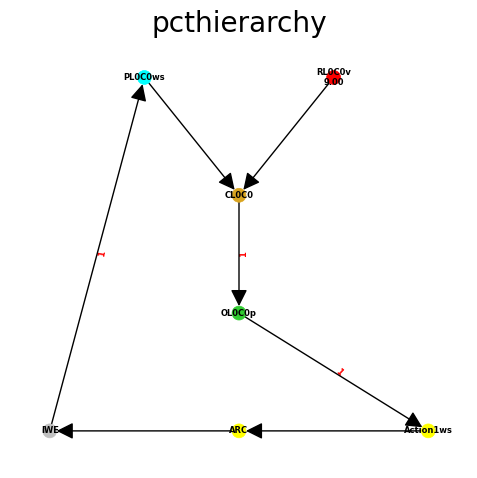

In [ ]:
#| gui
history=True
hierarchy, env = PCTHierarchy.load_from_file('testfiles/ARC/ga-000.000-s001-1x1-m007-ARC0010-9ddcf52416e60d65f19007957d07262d-consolidated.properties', min=True, render=True, history=history)
hierarchy.summary()

score, dfig, pfigs = PCTHierarchy.run_and_draw_hierarchy(hierarchy, env, draw_file=True, draw_figsize=(5,5), history = history, plots="scEdges,scZero", steps=50)#, draw_file='/tmp/tmp.png')
print(score)
# print(dfig)
dfig


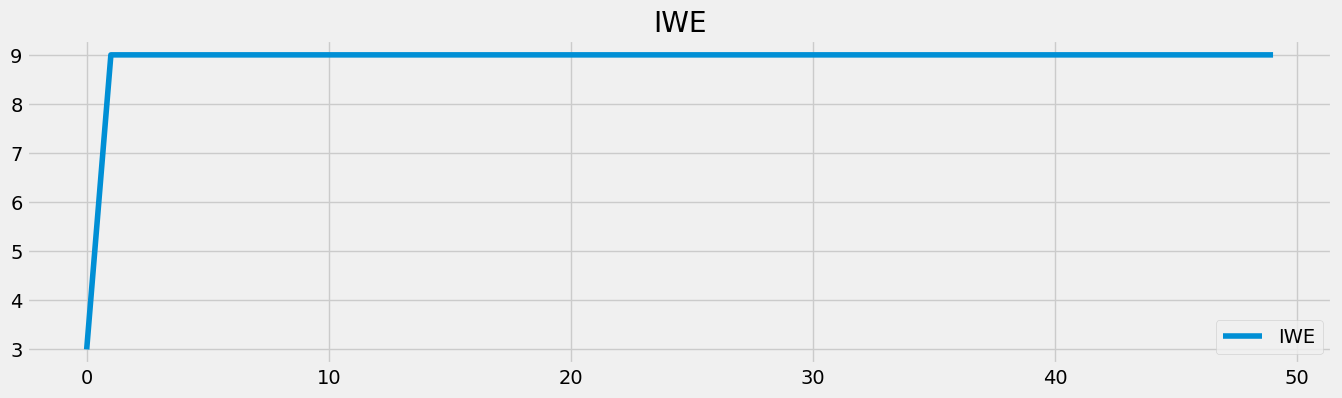

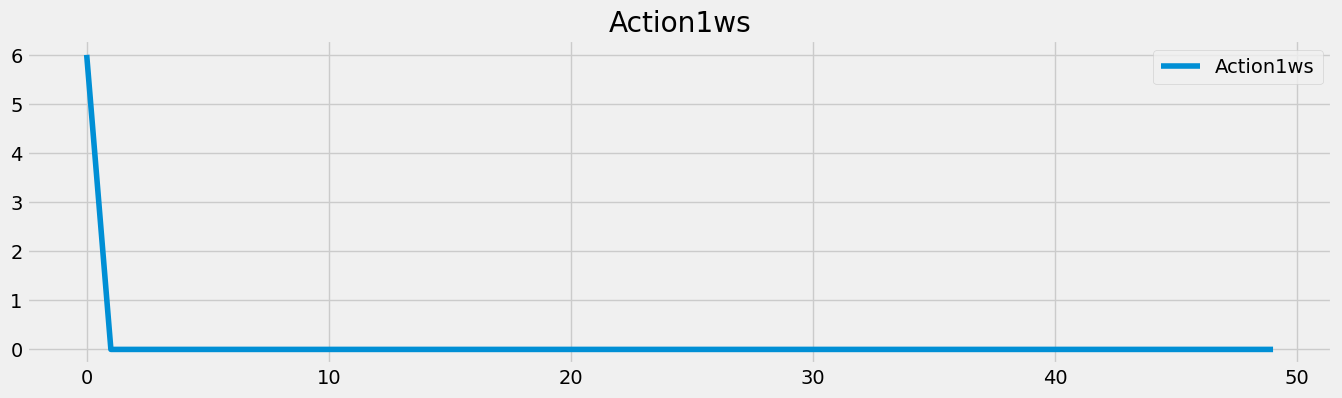

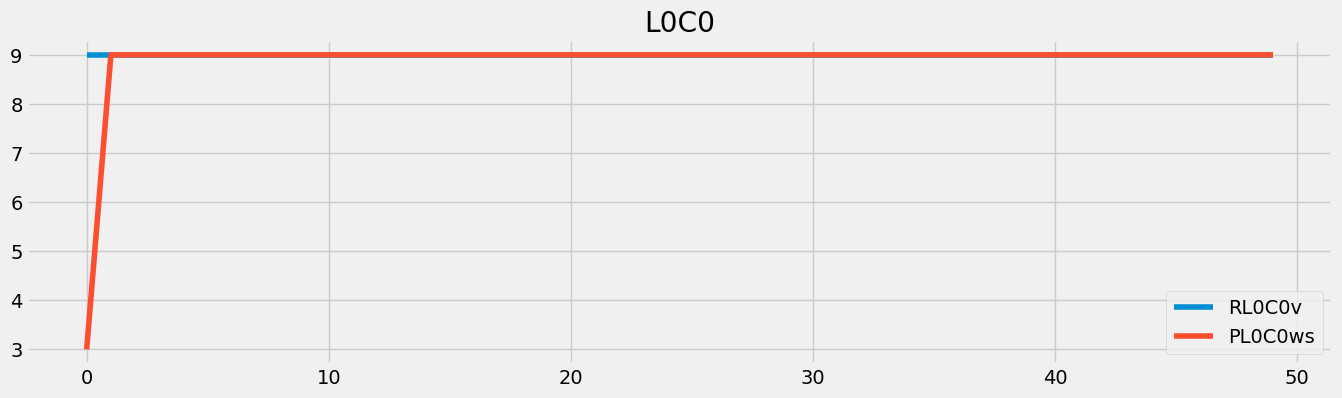

In [ ]:
#| gui

for pfig in pfigs:
    display(pfig)


## Creating a Hierarchy

Create a hierarchy by defining the number of rows (levels) and columns.

In [ ]:
from pct.functions import Constant

In [ ]:
pre=Constant(5, name='precon')
namespace=pre.namespace
post=Constant(10, name='postcon', namespace=namespace)
hpct = PCTHierarchy(3,3, pre=[pre], post=[post], history=True, clear_names=False, links="dense", namespace=namespace)
hpct.hierarchy


[[<pct.nodes.PCTNode>,
  <pct.nodes.PCTNode>,
  <pct.nodes.PCTNode>],
 [<pct.nodes.PCTNode>,
  <pct.nodes.PCTNode>,
  <pct.nodes.PCTNode>],
 [<pct.nodes.PCTNode>,
  <pct.nodes.PCTNode>,
  <pct.nodes.PCTNode>]]

In [ ]:
print(hpct.get_summary())

**************************
PRE: 5.000 
L0C0 0.000 0.000 0.000 0.000 
L0C1 0.000 0.000 0.000 0.000 
L0C2 0.000 0.000 0.000 0.000 
L1C0 0.000 0.000 0.000 0.000 
L1C1 0.000 0.000 0.000 0.000 
L1C2 0.000 0.000 0.000 0.000 
L2C0 0.000 0.000 0.000 0.000 
L2C1 0.000 0.000 0.000 0.000 
L2C2 0.000 0.000 0.000 0.000 
POST: 10.000 



In [ ]:
print(hpct.get_parameters_list())

[[[[5]], [[10]]], [[[[1, 1, 1]], [[0]], [[1]]], [[[1, 1, 1]], [[0]], [[1]]], [[[1, 1, 1]], [[0]], [[1]]]], [[[[1, 1, 1]], [[1, 1, 1]], [[1]]], [[[1, 1, 1]], [[1, 1, 1]], [[1]]], [[[1, 1, 1]], [[1, 1, 1]], [[1]]]], [[[[0]], [[1, 1, 1]], [[1]]], [[[0]], [[1, 1, 1]], [[1]]], [[[0]], [[1, 1, 1]], [[1]]]]]


In [ ]:
print(hpct.get_grid())

[3, 3, 3]


In [ ]:
hpct.change_namespace()

In [ ]:
hpct.summary()

**************************
pcthierarchy PCTHierarchy [3, 3, 3] be730f12-4929-11ef-ab73-5c879c15de65
--------------------------
PRE: precon Constant | 5 
Level 0 Cols 3
level0col0 PCTNode be730f12-4929-11ef-ab73-5c879c15de65
----------------------------
REF: weighted_sum WeightedSum | weights [1, 1, 1] | 0 | links  proportional3 proportional4 proportional5 
PER: variable Variable | 0 
COM: subtract Subtract | 0 | links  weighted_sum variable 
OUT: proportional Proportional | gain 1 | 0 | links  subtract 
----------------------------
level0col1 PCTNode be730f12-4929-11ef-ab73-5c879c15de65
----------------------------
REF: weighted_sum1 WeightedSum | weights [1, 1, 1] | 0 | links  proportional3 proportional4 proportional5 
PER: variable1 Variable | 0 
COM: subtract1 Subtract | 0 | links  weighted_sum1 variable1 
OUT: proportional1 Proportional | gain 1 | 0 | links  subtract1 
----------------------------
level0col2 PCTNode be730f12-4929-11ef-ab73-5c879c15de65
----------------------------


In [ ]:
#FunctionsList.getInstance().report()    

Create a hierarchy from a configuration.

In [ ]:
config = hpct.get_config()
print(config)

{'type': 'PCTHierarchy', 'name': 'pcthierarchy', 'pre': {'pre0': {'type': 'Constant', 'name': 'precon', 'value': 5, 'links': {}}}, 'levels': {'level0': {'level': 0, 'nodes': {'col0': {'col': 0, 'node': {'type': 'PCTNode', 'name': 'level0col0', 'refcoll': {'0': {'type': 'WeightedSum', 'name': 'weighted_sum', 'value': 0, 'links': {0: 'proportional3', 1: 'proportional4', 2: 'proportional5'}, 'weights': [1, 1, 1]}}, 'percoll': {'0': {'type': 'Variable', 'name': 'variable', 'value': 0, 'links': {}}}, 'comcoll': {'0': {'type': 'Subtract', 'name': 'subtract', 'value': 0, 'links': {0: 'weighted_sum', 1: 'variable'}}}, 'outcoll': {'0': {'type': 'Proportional', 'name': 'proportional', 'value': 0, 'links': {0: 'subtract'}, 'gain': 1}}}}, 'col1': {'col': 1, 'node': {'type': 'PCTNode', 'name': 'level0col1', 'refcoll': {'0': {'type': 'WeightedSum', 'name': 'weighted_sum1', 'value': 0, 'links': {0: 'proportional3', 1: 'proportional4', 2: 'proportional5'}, 'weights': [1, 1, 1]}}, 'percoll': {'0': {'ty

In [ ]:
# h = PCTHierarchy.from_config(config, namespace=namespace)
h = PCTHierarchy.from_config(config)

In [ ]:
assert h.get_config() == hpct.get_config()

## Viewing a Hierarchy

The hierarchy details can be viewed as a summary. 

In [ ]:
hpct.get_node(2,0).get_function('reference').set_value(1)
hpct.get_node(2,1).get_function('reference').set_value(1)
hpct.get_node(2,2).get_function('reference').set_value(1)
for level in range(3):
    for col in range(3):
        hpct.get_node(level,col).get_function('output').set_property('gain', 10)
hpct.summary()

**************************
pcthierarchy PCTHierarchy [3, 3, 3] be730f12-4929-11ef-ab73-5c879c15de65
--------------------------
PRE: precon Constant | 5 
Level 0 Cols 3
level0col0 PCTNode be730f12-4929-11ef-ab73-5c879c15de65
----------------------------
REF: weighted_sum WeightedSum | weights [1, 1, 1] | 0 | links  proportional3 proportional4 proportional5 
PER: variable Variable | 0 
COM: subtract Subtract | 0 | links  weighted_sum variable 
OUT: proportional Proportional | gain 10 | 0 | links  subtract 
----------------------------
level0col1 PCTNode be730f12-4929-11ef-ab73-5c879c15de65
----------------------------
REF: weighted_sum1 WeightedSum | weights [1, 1, 1] | 0 | links  proportional3 proportional4 proportional5 
PER: variable1 Variable | 0 
COM: subtract1 Subtract | 0 | links  weighted_sum1 variable1 
OUT: proportional1 Proportional | gain 10 | 0 | links  subtract1 
----------------------------
level0col2 PCTNode be730f12-4929-11ef-ab73-5c879c15de65
---------------------------

The hierarchy details can be viewed as a configuration. That configuration can be used to create a hierarchy, as shown above.

In [ ]:
hpct.get_config()

{'type': 'PCTHierarchy',
 'name': 'pcthierarchy',
 'pre': {'pre0': {'type': 'Constant',
   'name': 'precon',
   'value': 5,
   'links': {}}},
 'levels': {'level0': {'level': 0,
   'nodes': {'col0': {'col': 0,
     'node': {'type': 'PCTNode',
      'name': 'level0col0',
      'refcoll': {'0': {'type': 'WeightedSum',
        'name': 'weighted_sum',
        'value': 0,
        'links': {0: 'proportional3', 1: 'proportional4', 2: 'proportional5'},
        'weights': [1, 1, 1]}},
      'percoll': {'0': {'type': 'Variable',
        'name': 'variable',
        'value': 0,
        'links': {}}},
      'comcoll': {'0': {'type': 'Subtract',
        'name': 'subtract',
        'value': 0,
        'links': {0: 'weighted_sum', 1: 'variable'}}},
      'outcoll': {'0': {'type': 'Proportional',
        'name': 'proportional',
        'value': 0,
        'links': {0: 'subtract'},
        'gain': 10}}}},
    'col1': {'col': 1,
     'node': {'type': 'PCTNode',
      'name': 'level0col1',
      'refcoll':

Get the output function, which will be the output function of the last node, or the last item of the post-processor functions, if present.

In [ ]:
link = hpct.get_output_function()
print(link.get_config())

{'type': 'Constant', 'name': 'postcon', 'value': 10, 'links': {}}


The hierarhcy can also be viewed graphically as a network of connected nodes.

In [ ]:
import os

In [ ]:
ahpct = PCTHierarchy(2,2, links="dense")

test = 3
if test==1:
    g = ahpct.graph()
    pos=graphviz_layout(g, prog='dot')
    nx.draw(g, pos=pos, with_labels=True, font_size=12, font_weight='bold', node_color='red',  node_size=500)

if test ==2:
    g = ahpct.graph()
    pos = nx.multipartite_layout(g, subset_key="layer", align='horizontal')
    pos['constant1'][0]+=0.2
    c = pos['constant1'][0]
    print(c)
    nx.draw(g, pos=pos, with_labels=True, font_weight='bold', node_color='red',  node_size=750, arrowsize=25)

if test ==3:
    if os.name=='nt':        
        ahpct.draw(file="ahpct.png",  node_size=1500, figsize=(10,10))# with_labels=True, font_weight='bold', node_color='red',  node_size=500, arrowsize=25, align='vertical'

## Running a hierarchy

The hierachy can be run once by calling itself. The verbose flag will print the computations to the screen.

In [ ]:
hpct(verbose=True)

5.000 
level0col0 [0, [0, 0, 0], [1, 1, 1]] 0.000 0.000 0.000 0.000 
level0col1 [0, [0, 0, 0], [1, 1, 1]] 0.000 0.000 0.000 0.000 
level0col2 [0, [0, 0, 0], [1, 1, 1]] 0.000 0.000 0.000 0.000 
level1col0 [0, [0, 0, 0], [1, 1, 1]] 0.000 [0, [0, 0, 0], [1, 1, 1]] 0.000 0.000 0.000 
level1col1 [0, [0, 0, 0], [1, 1, 1]] 0.000 [0, [0, 0, 0], [1, 1, 1]] 0.000 0.000 0.000 
level1col2 [0, [0, 0, 0], [1, 1, 1]] 0.000 [0, [0, 0, 0], [1, 1, 1]] 0.000 0.000 0.000 
level2col0 1.000 [0, [0, 0, 0], [1, 1, 1]] 0.000 1.000 10.000 
level2col1 1.000 [0, [0, 0, 0], [1, 1, 1]] 0.000 1.000 10.000 
level2col2 1.000 [0, [0, 0, 0], [1, 1, 1]] 0.000 1.000 10.000 
10.000 


10

A hierarchy can be executed with the "run()" method, providing the number of iterations to run. 

In [ ]:
hpct1 = PCTHierarchy(3,3, pre=[pre], post=[post], history=True, links="dense")
namespace=hpct1.namespace
hpct1.get_node(2,0).get_function('reference').set_value(1)
hpct1.get_node(2,1).get_function('reference').set_value(1)
hpct1.get_node(2,2).get_function('reference').set_value(1)
for level in range(3):
    for col in range(3):
        hpct1.get_node(level,col).get_function('output').set_property('gain', 10)

hpct1.run(10)

10

## Viewing Data

If the hierarchy is created with the "history" flag equal to True, the data can be retrieved for each node. The node is accessed by specifying the row and column within the hierarchy. 

In [ ]:
print(hpct1.get_node(1,1).history.data)
assert hpct1.get_node(1,1).history.data == {'refcoll': {'weighted_sum6': [0.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0]}, 'percoll': {'weighted_sum5': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, 'comcoll': {'subtract4': [0.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0]}, 'outcoll': {'proportional4': [0.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0]}}

{'refcoll': {'weighted_sum6': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30]}, 'percoll': {'weighted_sum5': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}, 'comcoll': {'subtract4': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30]}, 'outcoll': {'proportional4': [0, 300, 300, 300, 300, 300, 300, 300, 300, 300]}}


## Save and Load

Save a hierarchy to file.

In [ ]:
import json

In [ ]:
hpct1.save("hpct.json")

Create a hierarchy from file.

In [ ]:
#loaded = PCTHierarchy.load("hpct.json", clear=False, namespace=namespace)
loaded = PCTHierarchy.load("hpct.json", clear=False)
loaded.summary()

**************************
pcthierarchy PCTHierarchy [3, 3, 3] bf4bb763-4929-11ef-a9e7-5c879c15de65
--------------------------
PRE: precon Constant | 5 
Level 0 Cols 3
level0col0 PCTNode bf4bb763-4929-11ef-a9e7-5c879c15de65
----------------------------
REF: weighted_sum WeightedSum | weights [1, 1, 1] | 900 | links  proportional3 proportional4 proportional5 
PER: variable Variable | 0 
COM: subtract Subtract | 900 | links  weighted_sum variable 
OUT: proportional Proportional | gain 10 | 9000 | links  subtract 
----------------------------
level0col1 PCTNode bf4bb763-4929-11ef-a9e7-5c879c15de65
----------------------------
REF: weighted_sum1 WeightedSum | weights [1, 1, 1] | 900 | links  proportional3 proportional4 proportional5 
PER: variable1 Variable | 0 
COM: subtract1 Subtract | 900 | links  weighted_sum1 variable1 
OUT: proportional1 Proportional | gain 10 | 9000 | links  subtract1 
----------------------------
level0col2 PCTNode bf4bb763-4929-11ef-a9e7-5c879c15de65
-------------

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

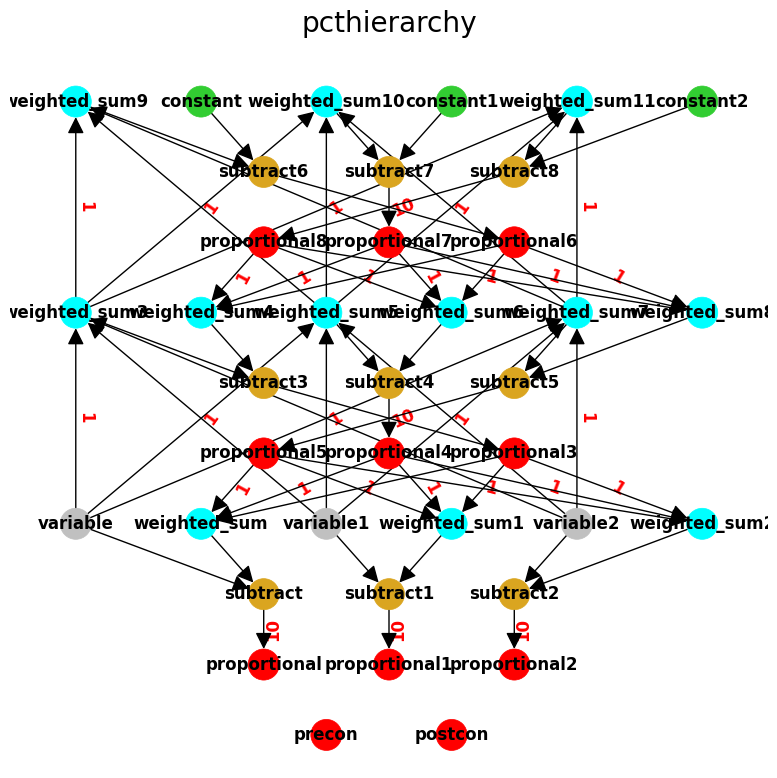

In [ ]:
# https://matplotlib.org/3.1.0/gallery/color/named_colors.html
loaded.draw(with_edge_labels=True, color_mapping={'w':'aqua','c':'limegreen','s':'goldenrod', 'p':'red', 'v':'silver'})

###### Examples


Build a hierarchy by adding nodes and functions manually.

Create an empty hierarchy.

In [ ]:
myhpct = PCTHierarchy()
namespace=myhpct.namespace
myhpct.summary(build=False)

**************************
pcthierarchy PCTHierarchy [] bfcf1835-4929-11ef-8fc3-5c879c15de65
--------------------------
PRE: None
POST: None
**************************


Add a node. Then nodes at particular positions.

In [ ]:
myhpct.add_node(PCTNode(namespace=namespace))
myhpct.add_node(PCTNode(namespace=namespace), level=1)
myhpct.add_node(PCTNode(namespace=namespace), level=0)
myhpct.summary(build=False)

**************************
pcthierarchy PCTHierarchy [2, 1] bfcf1835-4929-11ef-8fc3-5c879c15de65
--------------------------
PRE: None
Level 0 Cols 2
pctnode2 PCTNode bfcf1835-4929-11ef-8fc3-5c879c15de65
----------------------------
REF: constant2 Constant | 0 
PER: variable2 Variable | 0 
COM: subtract2 Subtract | 0 
OUT: proportional2 Proportional | gain 1 | 0 
----------------------------
pctnode PCTNode bfcf1835-4929-11ef-8fc3-5c879c15de65
----------------------------
REF: constant Constant | 0 
PER: variable Variable | 0 
COM: subtract Subtract | 0 
OUT: proportional Proportional | gain 1 | 0 
----------------------------
Level 1 Cols 1
pctnode1 PCTNode bfcf1835-4929-11ef-8fc3-5c879c15de65
----------------------------
REF: constant1 Constant | 0 
PER: variable1 Variable | 0 
COM: subtract1 Subtract | 0 
OUT: proportional1 Proportional | gain 1 | 0 
----------------------------
POST: None
**************************


Replace functions at particular positions in the hierarchy.

In [ ]:
myhpct.insert_function(level=0, col=0, collection="perception", function=Proportional(3, name="prop2", namespace=namespace))
myhpct.insert_function(level=1, col=0, collection="perception", function=WeightedSum(weights=[1,1], name="wsum", namespace=namespace))
myhpct.insert_function(level=0, col=1, collection="reference", function=Proportional(1, name="passthru", namespace=namespace))

Add pre and post processor functions.

In [ ]:
myhpct.add_preprocessor(Constant(1, name="cons1", namespace=namespace))
myhpct.add_preprocessor(Proportional(5, name="prop1", namespace=namespace))
myhpct.add_postprocessor(Proportional(5, name="postprop1", namespace=namespace))
myhpct.add_postprocessor(Proportional(5, name="postprop2", namespace=namespace))

Link the functions together.

In [ ]:
myhpct.set_links("prop1", "cons1")
myhpct.set_links("prop2", "prop1")
myhpct.add_links("wsum", "prop2", "variable")
myhpct.set_links("passthru", "proportional1")
myhpct.set_links("postprop1", "proportional")
myhpct.set_links("postprop2", "postprop1")

In [ ]:
myhpct.get_node(0,0).get_function('reference').set_value(1)
myhpct.get_node(1,0).get_function('reference').set_value(1)
myhpct.get_node(0,0).get_function('output').set_property('gain', 10)
myhpct.get_node(0,1).get_function('output').set_property('gain', 10)
myhpct.get_node(1,0).get_function('output').set_property('gain', 10)
myhpct.summary(build=True)

**************************
pcthierarchy PCTHierarchy [2, 1] bfcf1835-4929-11ef-8fc3-5c879c15de65
--------------------------
PRE: cons1 Constant | 1 
prop1 Proportional | gain 5 | 0 | links  cons1 
Level 0 Cols 2
pctnode2 PCTNode bfcf1835-4929-11ef-8fc3-5c879c15de65
----------------------------
REF: constant2 Constant | 1 
PER: prop2 Proportional | gain 3 | 0 | links  prop1 
COM: subtract2 Subtract | 0 | links  constant2 prop2 
OUT: proportional2 Proportional | gain 10 | 0 | links  subtract2 
----------------------------
pctnode PCTNode bfcf1835-4929-11ef-8fc3-5c879c15de65
----------------------------
REF: passthru Proportional | gain 1 | 0 | links  proportional1 
PER: variable Variable | 0 
COM: subtract Subtract | 0 | links  passthru variable 
OUT: proportional Proportional | gain 10 | 0 | links  subtract 
----------------------------
Level 1 Cols 1
pctnode1 PCTNode bfcf1835-4929-11ef-8fc3-5c879c15de65
----------------------------
REF: constant1 Constant | 1 
PER: wsum WeightedSum | w

In [ ]:
myhpctconfig = myhpct.get_config()
#print(myhpctconfig)
assert myhpctconfig == {'type': 'PCTHierarchy', 'name': 'pcthierarchy', 'pre': {'pre0': {'type': 'Constant', 'name': 'cons1', 'value': 1, 'links': {}}, 'pre1': {'type': 'Proportional', 'name': 'prop1', 'value': 0, 'links': {0: 'cons1'}, 'gain': 5}}, 'levels': {'level0': {'level': 0, 'nodes': {'col0': {'col': 0, 'node': {'type': 'PCTNode', 'name': 'pctnode2', 'refcoll': {'0': {'type': 'Constant', 'name': 'constant2', 'value': 1, 'links': {}}}, 'percoll': {'0': {'type': 'Proportional', 'name': 'prop2', 'value': 0, 'links': {0: 'prop1'}, 'gain': 3}}, 'comcoll': {'0': {'type': 'Subtract', 'name': 'subtract2', 'value': 0, 'links': {0: 'constant2', 1: 'prop2'}}}, 'outcoll': {'0': {'type': 'Proportional', 'name': 'proportional2', 'value': 0, 'links': {0: 'subtract2'}, 'gain': 10}}}}, 'col1': {'col': 1, 'node': {'type': 'PCTNode', 'name': 'pctnode', 'refcoll': {'0': {'type': 'Proportional', 'name': 'passthru', 'value': 0, 'links': {0: 'proportional1'}, 'gain': 1}}, 'percoll': {'0': {'type': 'Variable', 'name': 'variable', 'value': 0, 'links': {}}}, 'comcoll': {'0': {'type': 'Subtract', 'name': 'subtract', 'value': 0, 'links': {0: 'passthru', 1: 'variable'}}}, 'outcoll': {'0': {'type': 'Proportional', 'name': 'proportional', 'value': 0, 'links': {0: 'subtract'}, 'gain': 10}}}}}}, 'level1': {'level': 1, 'nodes': {'col0': {'col': 0, 'node': {'type': 'PCTNode', 'name': 'pctnode1', 'refcoll': {'0': {'type': 'Constant', 'name': 'constant1', 'value': 1, 'links': {}}}, 'percoll': {'0': {'type': 'WeightedSum', 'name': 'wsum', 'value': 0, 'links': {0: 'prop2', 1: 'variable'}, 'weights': [1.0, 1.0]}}, 'comcoll': {'0': {'type': 'Subtract', 'name': 'subtract1', 'value': 0, 'links': {0: 'constant1', 1: 'wsum'}}}, 'outcoll': {'0': {'type': 'Proportional', 'name': 'proportional1', 'value': 0, 'links': {0: 'subtract1'}, 'gain': 10}}}}}}}, 'post': {'post0': {'type': 'Proportional', 'name': 'postprop1', 'value': 0, 'links': {0: 'proportional'}, 'gain': 5}, 'post1': {'type': 'Proportional', 'name': 'postprop2', 'value': 0, 'links': {0: 'postprop1'}, 'gain': 5}}}

Define the order in which the node will be processed.

In [ ]:
myhpct.set_order(["pctnode2", "pctnode1", "pctnode"])

Run the hierarchy once.

In [ ]:
out = myhpct(verbose=True)
print(out)
assert out == -35000

1.000 5.000 
pctnode2 1.000 15.000 -14.000 -140.000 
pctnode1 1.000 [15, [15, 0], [1, 1]] 15.000 -14.000 -140.000 
pctnode -140.000 0.000 -140.000 -1400.000 
-7000.000 -35000.000 
-35000


In [ ]:
# config =  {'type': 'Individual', 'name': 'pcthierarchy', 'pre': {'pre0': {'type': 'CartPoleV1', 'name': 'CartPoleV1', 'value': [0.03498833197860944, 0.20994561633454428, 0.012668159509212712, -0.2705237130920193, 0.047656152654718356], 'links': {0: 'Action1'}, 'env_name': 'CartPole-v1', 'reward': 1.0, 'done': False, 'info': {}}, 'pre1': {'type': 'IndexedParameter', 'name': 'ICV', 'value': 0.20994561633454428, 'links': {0: 'CartPoleV1'}, 'index': 1}, 'pre2': {'type': 'IndexedParameter', 'name': 'ICP', 'value': 0.03498833197860944, 'links': {0: 'CartPoleV1'}, 'index': 0}, 'pre3': {'type': 'IndexedParameter', 'name': 'IPV', 'value': -0.2705237130920193, 'links': {0: 'CartPoleV1'}, 'index': 3}, 'pre4': {'type': 'IndexedParameter', 'name': 'IPA', 'value': 0.012668159509212712, 'links': {0: 'CartPoleV1'}, 'index': 2}}, 'levels': {'level0': {'level': 0, 'nodes': {'col0': {'col': 0, 'node': {'type': 'PCTNode', 'name': 'L0C0', 'refcoll': {'0': {'type': 'EAConstant', 'name': 'RL0C0', 'value': 0, 'links': {}}}, 'percoll': {'0': {'type': 'EAWeightedSum', 'name': 'PL0C0', 'value': -0.2705237130920193, 'links': {0: 'ICV', 1: 'ICP', 2: 'IPV', 3: 'IPA'}, 'weights': [0, 0, 1, 0]}}, 'comcoll': {'0': {'type': 'Subtract', 'name': 'CL0C0', 'value': 0.2705237130920193, 'links': {0: 'RL0C0', 1: 'PL0C0'}}}, 'outcoll': {'0': {'type': 'EAProportional', 'name': 'OL0C0', 'value': -0.05046166000036782, 'links': {0: 'CL0C0'}, 'gain': -0.1865332226280776}}}}}}}, 'post': {'post0': {'type': 'EAWeightedSum', 'name': 'Action1', 'value': -0.005282911840894066, 'links': {0: 'OL0C0'}, 'weights': [0.10469159835121472]}}}
# ind = PCTHierarchy.from_config(config)

In [ ]:
from pct.errors import RootSumSquaredError, TotalError

er = RootSumSquaredError()
te = TotalError(error_response=er, limit=250,min=True)   
te.add_error_data([1, 2])
print(te)


hpct = PCTHierarchy(1,1,error_collector=te)
hpct.run(steps=5, verbose=True)


err=te.error()
print(err)


TotalError limit:250, limit_exceeded:False, : RootSumSquaredError error_response:2.23606797749979
[0] 
level0col0 0.000 0.000 0.000 0.000 

Current score=2.23606797749979
[1] 
level0col0 0.000 0.000 0.000 0.000 

Current score=2.23606797749979
[2] 
level0col0 0.000 0.000 0.000 0.000 

Current score=2.23606797749979
[3] 
level0col0 0.000 0.000 0.000 0.000 

Current score=2.23606797749979
[4] 
level0col0 0.000 0.000 0.000 0.000 

Current score=2.23606797749979
2.23606797749979


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()